# Lab Week 9 - solution

## EOSC 211

### Learning Objectives:

1. Writing functions with optional arguments

2. Learn some stylish, *pythonic* tricks for writing clean, succinct functions

3. Write a large, well-organized program which implements a *module*

<img src="example_figure.png" width="60%">

## Intro

This lab is about using functions and modules to keep code organized even when the data analysis gets large and complex. So far, we have been mostly concerned with the finer details of python syntax and the building blocks that make up the language. Learning a programming language is not that different than learning a spoken language -- now that we have mastered the A,B,C's and can put words together to form sentences, it's time to scale up and write a bona-fide essay. 

Sometime soon in your EOSC career, you will be asked to complete a project that requires analysis of a dataset and a subsequent report of your techniques and the conclusions you draw from your research. More often than not, the person to whom you submit your report is much more interested in the "science," and less interested in nitty-gritty bits of code you used to get there. (They might be less well-versed in python, or maybe they don't speak code at all!) Your analysis should therefore contain only the few lines of code needed illustrate where you got your data, the steps taken to process it, and a scientific figure which effectively communicates the final result.

A great way to accomplish this is to implement the majority of your code in a *function module*, a separate python program that contains the functions you created to accomplish your analysis, and a *main script* which contains your only minimalist code cells that call functions imported from your library, and to accompany this with some written exposition on the topic at hand.

### Your Task

This week we are interested in exploring the ocean surface-currents during the summer months (averaged over May, June and July). Our raw data is in the file `mgsva_MJJ.csv`, and most of the functions are already provided to get the data, perform some analysis and generate a map of surface currents. 

Your task is to add some additional capability, then *package* these functions in a *module*, and finally write a a *main script* that calls functions imported from your module and includes any report text / commenting needed. More generally speaking, programmers refer to these as two types of code as *back-end* (used to do stuff) and *front-end* (used for nicely presenting stuff). 

Aside: There is a good plain English article __[here](https://learnpython.com/blog/python-modules-packages-libraries-frameworks/)__  that explains the difference between modules, packages, libraries and even frameworks. 

The easiest way to remember the heirarchy is *functions=paragraphs, modules=chapters, packages=books*.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
#import this # what happens if you un-comment this line?

## Part 1: Creating Useful Functions (Tutorial)

Functions are the paragraphs of programming.  Like a good paragraph, a good function has a topic and a logical structure.  Paragraphs can be any length, but generally they are concise -- about 5-6 sentences.  If they get
longer than that, the reader begins to lose the plot, and the paragraph becomes "run-on".

### Function style

While all rules can be broken, these are good checkpoints to keep in mind when writing a function:

1. Functions should be small (usually less than 20 lines of code)
2. They should do one thing (Single Responsibility Principle)
3. Function argument lists should be limited to at most 4-5 variables
4. Function names should say what they do,and should be resemble verbs if possible
   ("calc_mean", "write_file", "read_data")
5. Functions should avoid "side effects"

   An example of a side effect: modifying a variable that has been passed to a function without returning
   that variable.  This kind of hidden action makes it difficult for a reader quickly determine
   what a function does.
   
Following these rules make it much easier to understand and debug a program.

Python has a few features that help in writing functions that are concise and easier to adapt for future use without having to rewrite old code.  

1. **Keyword arguments**  [Text Section 8.8](https://phaustin.github.io/Problem-Solving-with-Python/Functions-and-Modules/Positional-and-Keyword-Arguments.html#keyword-arguments)

   Optional keyword arguments.  Optional arguments can be used to keep the number of arguments passed
   to a function as small as possible. If these parameters are omitted, their default values are used
   instead. 
   In this example, we're using slice objects discussed in the [Oct. 7 notes](https://phaustin.github.io/eosc211_students/reference_notes/thursday_oct7.html):

In [2]:
def average_region(the_map, lat_slice=slice(0,-1), lon_slice=slice(0,-1)):
    print(f"\n{lat_slice.start=}, {lat_slice.stop=}, {lat_slice.step=}")
    print(f"{lon_slice.start=}, {lon_slice.stop=}, {lon_slice.step=}")
    mean_map = np.nanmean(the_map[lat_slice,lon_slice],axis=(0,1))
    return mean_map

avg_map=np.arange(0,90).reshape([9,10])
print(f"{average_region(avg_map)=}")
print(f"{average_region(avg_map,lat_slice=slice(3,7))=}")    


lat_slice.start=0, lat_slice.stop=-1, lat_slice.step=None
lon_slice.start=0, lon_slice.stop=-1, lon_slice.step=None
average_region(avg_map)=39.0

lat_slice.start=3, lat_slice.stop=7, lat_slice.step=None
lon_slice.start=0, lon_slice.stop=-1, lon_slice.step=None
average_region(avg_map,lat_slice=slice(3,7))=49.0


2. **Keyword expansion**

   Keyword expansion allows a user to call your function by passing a single dictionary with parameters, instead
   of having to list each parameter in the call.  This makes it easier to keep track of specific sets
   of parameters. An example:

In [3]:
pacific_nw_region = dict(lat_slice=slice(2,5),lon_slice=slice(3,6))
prairie_region = dict(lat_slice=slice(3,7),lon_slice=slice(8,9))
print(f"{average_region(avg_map,**pacific_nw_region)=}")
print(f"{average_region(avg_map,**prairie_region)=}")


lat_slice.start=2, lat_slice.stop=5, lat_slice.step=None
lon_slice.start=3, lon_slice.stop=6, lon_slice.step=None
average_region(avg_map,**pacific_nw_region)=34.0

lat_slice.start=3, lat_slice.stop=7, lat_slice.step=None
lon_slice.start=8, lon_slice.stop=9, lon_slice.step=None
average_region(avg_map,**prairie_region)=53.0


The keyword expansion operator `**` is called "double splat" and can also be used in a function definition to represent an unknown/arbitrary number of optional arguments.

In [4]:
def print_args(**my_args):
    print(f"{my_args=}")

print_args(a=5, b=7, c=10)

my_args={'a': 5, 'b': 7, 'c': 10}


3. **Function wrappers**
   
   You can expand a function's signature to create a new function with extra options.  Suppose you wanted
   to add a missing  value option to the `average_region` function.   You could do that by *wrapping* the
   function in an outer function.

In [5]:
def average_missing(the_map, lat_slice=slice(0,-1), lon_slice=slice(0,-1), missing_val=-999.):
    hit = (the_map == missing_val)
    new_map = np.array(the_map,dtype=np.float64)  #make a copy so no side effects
    new_map[hit]=np.nan
    out = average_region(new_map,lat_slice,lon_slice)
    return out

print(f"{average_missing(avg_map,**pacific_nw_region)=}")


lat_slice.start=2, lat_slice.stop=5, lat_slice.step=None
lon_slice.start=3, lon_slice.stop=6, lon_slice.step=None
average_missing(avg_map,**pacific_nw_region)=34.0


4. **Partial functions** (*not needed in this lab but useful to know about if you do a lot more coding*)

   Finally, suppose you want to slim your function arguments down by defining a new function with some of the
   default arguments defined.  You can do this using [partial functions](https://www.udacity.com/blog/2020/12/how-to-create-partial-functions-in-python.html).  Here's an example where you know you are always going to use -222 for missing data.

In [6]:
from functools import partial
my_average_missing=partial(average_missing,missing_val=-222)

new_map=np.array(avg_map)
new_map[2:3,3:4]=-222
print(f"{my_average_missing(new_map,**pacific_nw_region)=}")


lat_slice.start=2, lat_slice.stop=5, lat_slice.step=None
lon_slice.start=3, lon_slice.stop=6, lon_slice.step=None
my_average_missing(new_map,**pacific_nw_region)=35.375


### General form of python function signatures

In the same way that you can use a dictionary expansion to represent optional parameters, you can
also use a list expansion (`*args`) to expand a required list of arguments in a function call.
Here's an example:

In [7]:
def print_vars(*args,**kw):
    out=f"""
       {len(args)=}, {args=}
       {kw=}
    """
    print(out)
    
print_vars(1,2,3,a=5,b=6)
print_vars(height=5)
print_vars(1,2,3)


       len(args)=3, args=(1, 2, 3)
       kw={'a': 5, 'b': 6}
    

       len(args)=0, args=()
       kw={'height': 5}
    

       len(args)=3, args=(1, 2, 3)
       kw={}
    


## Part 2: Write Your Own Module (Tutorial)

Once our code has been packaged in succinct functions with no side effects, we can export it as a module and call our functions from other scripts. In the lab folder, you will find a file called `example_funcs.py`. We want to run these functions from the current notebook. To do this, use the familiar syntax to import functions from a module:

In [8]:
import example_funcs
# or from example_funcs import earth
# or import example_funcs as ef

and run the function with:

In [9]:
example_funcs.earth()

'Harmless'

If you wish to add to or modify functions in a module, do the following:

1) From the `lab_wk9` jupyter notebook: 

**(a)** Go to `File` $\rightarrow$ [Open] to get the file list, then   
**(b)** tick the box next to `example_funcs.py`, 
        you get new actions:  
        [Duplicate], [Rename], [Move], [Download], [View], [Edit], [Trashcan].        
**(c)**      Clicking on [edit] opens `example_funcs.py` in a simple python editor.

2) Apply your changes to the `example_funcs.py` file, save them.

3) Go back to your main notebook (i.e. this notebook), restart the kernel 

($\blacktriangleright\blacktriangleright$), re-run the `import example_funcs` cell. 

The changes should now be in effect for any subsequent executions of functions in the `example_funcs.py` module.

Try it yourself! Use steps 1-3 to modify the function `earth()` to return the string `"Mostly harmless"` instead of its current message. Make sure the changes are reflected when you run the function from inside this notebook.

## Part 3: Apply to Real Data Analysis

### Objective 1:  Getting oriented with the task at hand.

Read through the code in the cell below Part 3.  There are several functions that will accomplish the following tasks: (1) reading and parsing the data, (2) turning the east and north components of ocean currents into 2D grids, (3) computing a 2D running mean, (4) masking out unwanted points for plotting purposes, (5) making a plot, (6) select a sub-region from a 2D grid using a function that you will write, using the function signature provided.

The functions will be the back-end of the lab - you can use these as written, with the exception of the select_region function which you will write.  These functions will be placed into a module, that you can call from  your main script.  You will then write a main script that will load the data, make a 2D grid, select a subregion, compute the moving average, and make a plot.

#### A few more details on the data analysis
`move_to_grid()`: The first step in the data analysis (after reading and parsing the data) is done by calling the function move_to_grid(). This function 2D grids of the north and east velocities from the input 1D arrays, and longitude and latitude arrays corresponding to columns and rows respectively (like the topo data in previous labs). Land locations contain NaN.

`mean2d()`: Then, we want to smooth the data a bit. We have dealt with running mean windows in 1D (for time series). This is generalized to a 2D case, which we are implementing with the function mean2d(). For a ‘window size’ of N (again with N odd) average the points in an NxN square centered on the location of the actual data point (draw a picture for yourself to make sure you understand how this works). For example, for a window size of 3, the 9 points within a 3 ×3 square surrounding the data point are averaged together.   Make sure you understand how the averaging works near the edges of the map, or if land points occur in the averaging window.  This kind of careful and precise working through of code can save you many, many hours of time in debugging / understanding any output.

### Objective 2:  write select_region()

Write a function called `select_region()`  which takes as input the full arrays produced by `move_to_grid` and outputs only data within a row/column slice specified in the function arguments. Note how we used the
slice object in Part 1. Your function should tick all the boxes from **Part 1** i.e. 
less than 5 required input args (or use keyword expansion), no *side effects*, etc.  We will be using slice objects as discussed  in Part 1 above.

Now write your select_region function. It should have a basic structure that looks like this

``` python
def select_region(lons=None, lats=None, u_vel=None, v_vel = None,
                 lon_slice=slice(0,360),lat_slice=slice(0,179): 
   #
   #  return, lons[lon_slice], lats[lat_slice] etc.
   #             
   do: slice lons, lats, u_vel and v_vel using lon_slice and lat_slice                 
return lons, lats, u_vel,v_vel
```

In [10]:
# select_region function solution
# Define your select_region function in this cell using the signature in the cell above
# 

### BEGIN SOLUTION
def select_region(lons=None, lats=None, u_vel=None, v_vel = None,
                  lon_slice=slice(0,360),lat_slice=slice(0,179)):
    """
    Write your sel
    """
    lats=lats[lat_slice]
    lons = lons[lon_slice]
    u_vel=u_vel[lat_slice,lon_slice]
    v_vel = v_vel[lat_slice,lon_slice]
    return lons, lats, u_vel,v_vel
### END SOLUTION

#### Test your select_region()

Run the code in the cell below to test your `select_region()` function.  It should produce the following output:
```python
np.shape(test_lons)=(36,),np.shape(test_lats)=(19,)
lon1=array([60, 70, 80])
lat1=array([ 0, 10, 20])
u1=array([[0.        , 0.        , 0.        ],
       [0.17101007, 0.11697778, 0.05939117],
       [0.3213938 , 0.21984631, 0.1116189 ]])
v1=array([[0.5       , 0.34202014, 0.17364818],
       [0.5       , 0.34202014, 0.17364818],
       [0.5       , 0.34202014, 0.17364818]])
```

Note that in Part 3  you will use the more sophisticated dictionary approach for the input arguments for `select_region`, but the example below should make it obvious what is needed later.

In [11]:
#
# select region test -- this should run successfully
#

test_lats = np.arange(-90,95,10)
test_lons = np.arange(0,360,10)
print(f"{np.shape(test_lons)=},{np.shape(test_lats)=}")
mx,my = np.meshgrid(test_lons,test_lats)
test_u = np.sin(np.deg2rad(2*my))*np.cos(np.deg2rad(mx))
test_v = np.cos(np.deg2rad(mx))
#plt.contourf(test_lons, test_lats, test_u) # uncomment if you want to see what test_u looks like

lon1,lat1,u1,v1=select_region(test_lons, test_lats, test_u, test_v,
                 lon_slice=slice(6,9),lat_slice=slice(9,12))
print(f"{lon1=}\n{lat1=}\n{u1=}\n{v1=}")

np.shape(test_lons)=(36,),np.shape(test_lats)=(19,)
lon1=array([60, 70, 80])
lat1=array([ 0, 10, 20])
u1=array([[0.        , 0.        , 0.        ],
       [0.17101007, 0.11697778, 0.05939117],
       [0.3213938 , 0.21984631, 0.1116189 ]])
v1=array([[0.5       , 0.34202014, 0.17364818],
       [0.5       , 0.34202014, 0.17364818],
       [0.5       , 0.34202014, 0.17364818]])


### Objective 3

Once you have tested your `select_region()` function, export all the functions in the cell below labeled **functions for export** to a module called `lab9_funcs.py`, save it in the same folder as the lab and delete the cell with these functions from this lab notebook (**make a copy of this notebook first for backup**).

In the lab notebook (this notebook), import your module and write one more function called `main()` which uses the module to generate a map of averaged ocean currents in a selected lat, lon region.  `main()` should take 4 arguments which specify the lat/lon range to map (or a single dictionary containing 4 keys) and contain liberal amounts of commenting, explaining what is happening in each step.  To reiterate, `main` is in **this** notebook, not the functions module.

When you are finished, this notebook should contain < 20 lines of code (not including the tutorials above). This is the style of notebook we prefer for big projects, with minimal code which shows each step of the analysis but without displaying all the messy details.  

Finally, write two or three sentences max summarizing your results. **For the world map:** Are there any noticeable patterns in the summertime surface ocean currents? Where is the fastest current in the dataset and in which direction? **For your selected region** Where are the min and max currents and in which directions (if the min current is close to zero you might not be able to see the direction easily)?

### To Hand In

- This notebook, with your `main()` function and the map it produces, along with your analysis (patterns, fastest current)

- Your module `lab9_funcs.py`, which includes your `select_region()` function

To submit multiple files to the same assignment in Canvas, see [this link](https://unthsc-canvas.freshdesk.com/support/solutions/articles/44001929195-how-do-i-submit-multiple-documents-to-an-assignment-)

**Hints:**

1.  My solution called the functions in the following order:
```
    get_data_dict("mgsva_MJJ.csv")
    move_to_grid(**var_dict)
    bounds_dict = dict(lons=lons,lats=lats,u_vel=u,v_vel=v)
    # find start and stop for lon_slice given min_lon and max_lon (you need to write this code snippet)
    bounds_dict['lon_slice']=slice(start,stop)
    # find start and stop for lat_slice given min_lat and max_lat (you need to write this code snippet)
    bounds_dict['lat_slice']=slice(start,stop)
    select_region(**bounds_dict)
    mean2d(u, filter_width)
    mean2d(v, filter_width)
    mean2d(get_magnitudes(u, v), filter_width)
    mask_nth(u_filt, filter_width)
    mask_nth(v_filt, filter_width)
    do_plot(lats, lons, m_filt, u_masked, v_masked)
```
2.  First make sure your code works by plotting the map for the whole world.  It should look like the one at the top of this notebook.

3.  To do the array slicing you will need to find the indices of the rows and columns corresponding to the lat,lon limits for your chosen region.  `numpy.argwhere()` accomplishes this task.

###  Functions for export in the next cell

-- copy all the python code to `lab9_funs.py` (skip the quote marks at the very top and bottom of 
that tell Jupyter to format this as a python code block)
Don't forget to include your own version
of `select_region` in place of the stub file at the end of the cell

```python
import numpy as np
from matplotlib import pyplot as plt

def get_data_dict(filename):
    """
    Takes in "filename" (csv file) and outputs a dictionary containing
    keys:

         "lats"  - lattitude of each point
         "lons"  - longitude of each point
         "u_vel" - eastward velocity component
         "v_vel" - northward velocity component
    """
    the_file = np.genfromtxt(filename, delimiter=",")

    # extract variables from the csv
    # (namespaces are a honking great idea)
    var_dict = {
        "lats": the_file[:, 1],
        "lons": the_file[:, 2],
        "u_vel": the_file[:, 3],
        "v_vel": the_file[:, 4],
    }
    # extra information we dont need right now
    # "u_dev":the_file[:,5],
    # "v_dev":the_file[:,6]}
    return var_dict


def move_to_grid(lats, lons, u_vel, v_vel):
    """

    function to create 2D numpy arrays out of FORTRAN formatted csv data

    function to create 2D arrays out of FORTRAN formatted csv data.  
    Assumes user wants a 1 deg by 1 deg grid.

    in:
    csv file with columns 15000., lon, lat, u_vel, v_vel, u_dev, v_dev

    (dev is the standard deviation of each velocity measurement, 15000.
    is an artifact from FORTRAN formatting)

    out:
    1D arrays: lat_0, lon_0
    2D arrays: u, v
    """
    # set up grids
    # initializing with NaNs also automatically deals with points where there is
    # no data (eg. on land) because those locations will simply contain NaNs

    lon_0 = np.arange(-179, 180)
    lat_0 = np.arange(-89, 89)
    
    lon_0 = np.arange(-179, 181)
    lat_0 = np.arange(-89, 90)   # CJ modified to 90 so goes -89 to 89
    
    nlat = len(lat_0)            # CJ added these two lines to reduce hardwiring.
    nlon = len(lon_0)
    
    u = np.full([nlat, nlon], np.nan)
    v = np.full([nlat, nlon], np.nan)

    # Loop through all points in .csv file.
    #
    # For each, calculate the row/col indices
    # from the lat/longs.  Lats get converted
    # into row indices 'i', and longs into column
    # indices 'j'. Since we have a 1 degree spacing
    # we just have to add the right offset
    # to make this work - for example, for latitudes
    # latitude of -89 goes to row 0,
    # latitude of -88 goes to row 1, etc.
    #
    # Then write the
    # corresponding U/V data for that lat/long
    # into the right place (i.e. index (i,j) )
    # in the U/V matrices
    for k in range(len(lats)):      # CJ changed from len(lats0) <-- was a bug
        i = int(lons[k]) + 78  # row index
        j = int(lats[k]) + 179  # column index
        u[i, j] = u_vel[k]
        v[i, j] = v_vel[k]

    return lon_0, lat_0, u, v


def mean2d(in_map, winlen):
    """
    Takes a 2D running mean of an input np array

    in:  winlen -- window length
         in_map -- numpy array on which to perform the running mean.

    assumes in_map is a world map, and wraps longitude[-1] around to [0]

    out: out_map -- the filtered map
    """

    def do_mean(in_map, winlen):
        # initialize output array and internal variables
        out_map = np.empty_like(in_map)
        out_map[:] = np.nan
        nrows, ncols = in_map.shape
        wn = int((winlen - 1) // 2)

        # loop through every point (i, j) in the grid:
        # (ignore edges for now)
        for i in range(wn, nrows - wn):
            for j in range(wn, ncols - wn):
                # don't filter points containing nan (ie land, edge of map)
                if not np.isfinite(in_map[i, j]):
                    out_map[i, j] = np.nan
                else:
                    # create the window
                    imin = i - wn
                    imax = i + wn + 1
                    jmin = j - wn
                    jmax = j + wn + 1

                    the_window = in_map[imin:imax, jmin:jmax]
                    # use nanmean to take the mean, ignoring nan values
                    out_map[i, j] = np.nanmean(the_window)

        return out_map

    # check for odd winlen
    winlen = int(winlen)
    if winlen % 2 == 0:
        winlen += 1

    return do_mean(in_map, winlen)


def mask_nth(in_map, n):
    """
    Decimates a 2d array with all values using every n-th
    value, and setting all empty grid cells to NaNs.
    in:
        in_map: 2d numpy array
        n: desired spacing of points

    out:
        masked_map: 2d numpy array with mask applied
    """
    masked_map = np.empty_like(in_map)
    masked_map[:] = np.nan
    masked_map[::n, ::n] = in_map[::n, ::n]
    return masked_map


def get_magnitudes(u, v):
    """
    takes in velocity components 'u' (int or float, array-like containing int or float)
    and 'v' (int or float, array-like containing int or float) and returns velocity magnitude

    m = (u^2 + v^2) ^ 0.5

    """
    return (u ** 2 + v ** 2) ** 0.5


def do_plot(lats, lons, m_filt, u_masked, v_masked):
    """
    Generates a plot of an input velocity field
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    vals=ax.contourf(lons, lats, m_filt, cmap="BuGn")
    cbar=fig.colorbar(vals)
    label=cbar.set_label("speed (m/s)",rotation=270, labelpad=15)
    ax.quiver(lons, lats, u_masked, v_masked, pivot="middle", scale=15)
    ax.set_title("Summertime Surface Ocean Currents")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    return None


def select_region():
    your function here
```

In [12]:
# HAND IN

# In this cell a main function that calls your functions and plots
# a map of the surface currents.  

# your main routine needs to have the following name and signature
# main(lon_min,lon_max,lat_min,lat_max)

# We will call main twice:
# once to plot the entire world (like the figure at the to of the page) 
# and a second time to plot an arbitray slice


# Note that I shorten lab9_funcs to l9fun so I can write
# l9fun.move_to_grid, l9fun.get_data_dict etc.


import lab9_funcs as l9fun
import numpy as np

### BEGIN SOLUTION
def main(lon_min,lon_max,lat_min,lat_max):
    # get the datafile
    filename = 'mgsva_MJJ.csv'

    # extract variables from the csv
    var_dict = l9fun.get_data_dict(filename)
    lons, lats, u, v = l9fun.move_to_grid(**var_dict)  # the honking great way
    
    # need to find rows,cols for slicing given lat, lons
    # we haven't actually shown them how to do this?
    
    # set up bounds for selected region
    bounds_dict = dict(lons=lons,lats=lats,u_vel=u,v_vel=v)
    # set up bounds for select region
    i1 = np.min(np.argwhere(lons>=lon_min)) 
    i2 = np.max(np.argwhere(lons<=lon_max))
    i3 = np.min(np.argwhere(lats>=lat_min)) 
    i4 = np.max(np.argwhere(lons<=lat_max))
    bounds_dict['lon_slice']=slice(i1,i2)
    bounds_dict['lat_slice']=slice(i3,i4)

    # grab selected region
    lons, lats, u, v = l9fun.select_region(**bounds_dict)
    print(lons.shape,lats.shape,u.shape,v.shape)
    # filter the velocity fields
    filter_width = 11
    u_filt = l9fun.mean2d(u, filter_width)
    v_filt = l9fun.mean2d(v, filter_width)
    m_filt = l9fun.mean2d(l9fun.get_magnitudes(u, v), filter_width)

    # apply mask to make nicely spaced arrows
    u_masked = l9fun.mask_nth(u_filt, filter_width)
    v_masked = l9fun.mask_nth(v_filt, filter_width)

    # do the plot
    l9fun.do_plot(lats, lons, m_filt, u_masked, v_masked)
    
    return None
### END SOLUTION

(100,) (179,) (179, 100) (179, 100)


(359,) (179,) (179, 359) (179, 359)


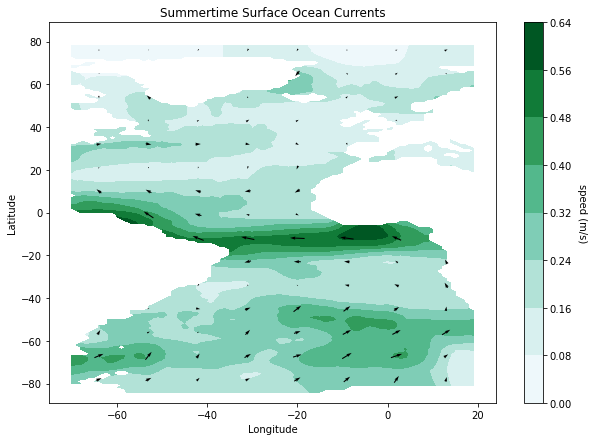

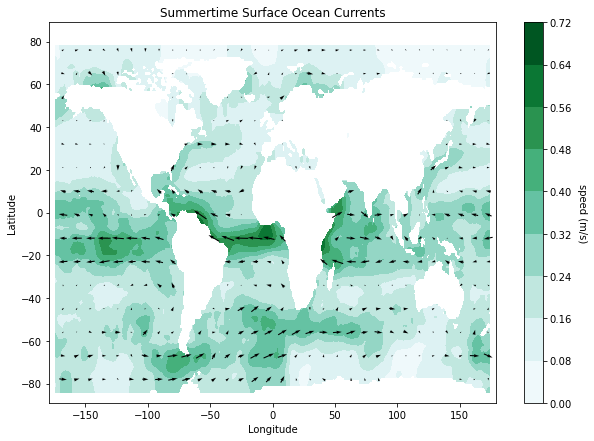

In [13]:
# hidden calls to main() here

### BEGIN HIDDEN TESTS
main(-75,25,-90,90)
main(-180,180,-90,90)
### END HIDDEN TESTS